In [22]:
import cv2
import os
import numpy as np
import skimage.feature
import matplotlib.pyplot as plt
import pandas as pd
from random import shuffle 
import pickle
%matplotlib inline

In [23]:
print (os.getcwd())

/Users/Kishor/Documents/NOAA-SeaLions


In [24]:
train_path = "data/TrainSmall2/Train/"
train_dotted_path = "data/TrainSmall2/TrainDotted/"
train_blob_path = "data/TrainSmall2/TrainBlob/"
file_names = os.listdir(train_path)

In [25]:
def filter_image_files(file_names):
    for f in file_names: 
        if f.endswith('.jpg'):
            pass
        else:
            file_names.remove(f) 
            
filter_image_files(file_names)

In [26]:
file_names

['41.jpg',
 '42.jpg',
 '43.jpg',
 '44.jpg',
 '45.jpg',
 '46.jpg',
 '47.jpg',
 '48.jpg',
 '49.jpg',
 '50.jpg']

### Sample Images

(3328, 4992, 3)


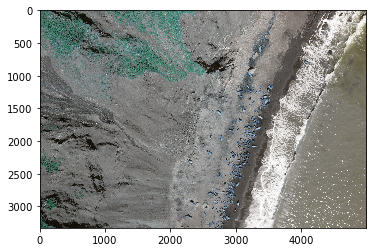

In [34]:
img = cv2.imread(train_path + file_names[0])
print (img.shape)
plt.imshow(img)
plt.show()

(3328, 4992, 3)


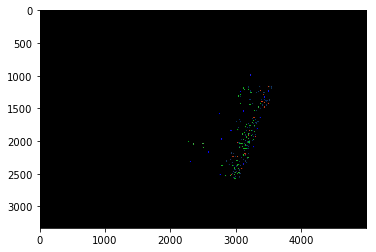

In [35]:
img = cv2.imread(train_blob_path + file_names[0])
print (img.shape)
plt.imshow(img)
plt.show()

In [29]:
# 3328, 4992, 3
def normalize(x): 
    return (x - float(np.min(x))) / (float(np.max(x)) - float(np.min(x)))

In [32]:
def resize_1(img, size): 
    return cv2.resize(img, size) 

def resize_2(img, fx, fy): 
    return cv2.resize(img, None, fx=fx, fy=fy) 

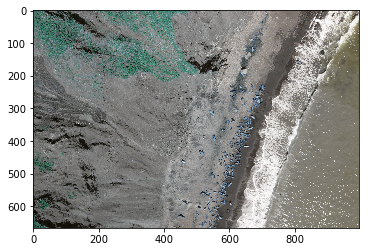

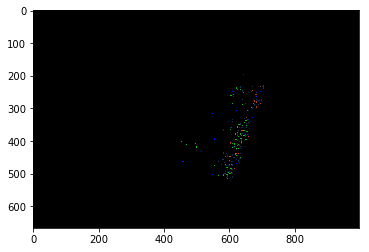

In [39]:
file_name = file_names[0]
img_1 = cv2.imread(train_path + file_name)
img_2 = cv2.imread(train_blob_path + file_name)

img_1 = normalize(img_1)
img_1 = resize_2(img_1, 0.2, 0.2)
plt.imshow(img_1)
plt.show()

img_2 = normalize(img_2)
img_2 = resize_2(img_2, 0.2, 0.2)
plt.imshow(img_2)
plt.show()




In [71]:
# def preprocess_and_save(train_path, train_blob_path): 
def preprocess(train_path, train_blob_path): 
    
    file_names = os.listdir(train_path)
    filter_image_files(file_names)
    shuffle(file_names)
    
    validation_count = int(len(file_names) * 0.1) 
    
    x = [] 
    y = [] 
    
    for f in file_names: 
        img_1 = cv2.imread(train_path + f)
        x.append(resize_1(img_1, (300,200)))
#         x.append(resize_2(img_1, 0.2, 0.2))
        
        img_2 = cv2.imread(train_blob_path + f)
        y.append(resize_1(img_2, (296,200)))        
#         y.append(resize_2(img_2, 0.2, 0.2))
        
    np_x = np.array(x)
    np_y = np.array(y) 
    
    np_x = normalize(np_x)
#     np_y = normalize(np_y)
        
    train_x = np_x[:-validation_count]
    train_y = np_y[:-validation_count]
    valid_x = np_x[-validation_count:]
    valid_y = np_y[-validation_count:]
    
#     print (train_x.shape)
#     print (train_y.shape)
#     print (valid_x.shape)
#     print (valid_y.shape)

    from sys import platform
    if platform != 'darwin': #OSError in MAC
        pickle.dump((train_x, train_y), open('train.p', 'wb'))
        pickle.dump((valid_x, valid_y), open('valid.p', 'wb'))

    return (train_x, train_y, valid_x, valid_y)

In [72]:
train_x, train_y, valid_x, valid_y = preprocess(train_path, train_blob_path)

### Neural Network

In [73]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, Cropping2D, Conv2DTranspose, UpSampling2D
from keras.utils import np_utils

In [89]:
model = Sequential()


model.add(Dense(32, input_shape=(200, 300,3)))

model.add(Conv2D(  64, (5, 5), activation='relu', strides=1, padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D( 256, (5, 5), activation='relu', strides=1, padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(1024, (5, 5), activation='relu', strides=1, padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# model.add(Conv2DTranspose(256, (3, 3), activation='relu', strides=1, padding='same'))
# model.add(Dropout(0.2))
# model.add(Conv2DTranspose(128, (3, 3), activation='relu', strides=1, padding='same'))
# model.add(Dropout(0.2))
# model.add(Conv2DTranspose( 64, (3, 3), activation='relu', strides=1, padding='same'))
# model.add(Dropout(0.2))
# model.add(Conv2DTranspose( 32, (3, 3), activation='relu', strides=1, padding='same'))
# model.add(Dropout(0.2))

model.add(UpSampling2D(size=(2,2)))
model.add(Conv2DTranspose(1024, (5, 5), activation='relu', strides=1, padding='same'))
model.add(Dropout(0.2))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2DTranspose( 256, (5, 5), activation='relu', strides=1, padding='same'))
model.add(Dropout(0.2))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2DTranspose(  64, (5, 5), activation='relu', strides=1, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2DTranspose(   3, (5, 5), activation='linear', strides=1, padding='same'))





# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, batch_size=2, epochs=10)

Epoch 1/10
9/9 [==============================] - 343s - loss: 2690883.1658    
Epoch 2/10
9/9 [==============================] - 311s - loss: 4.7482e-04    
Epoch 3/10
9/9 [==============================] - 311s - loss: 4.0826e-04    
Epoch 4/10
9/9 [==============================] - 309s - loss: 3.4802e-04    
Epoch 5/10
9/9 [==============================] - 376s - loss: 3.1171e-04    
Epoch 6/10
9/9 [==============================] - 315s - loss: 3.1313e-04    
Epoch 7/10
9/9 [==============================] - 311s - loss: 3.1449e-04    
Epoch 8/10
9/9 [==============================] - 311s - loss: 3.1541e-04    
Epoch 9/10
9/9 [==============================] - 342s - loss: 3.1601e-04    
Epoch 10/10
9/9 [==============================] - 339s - loss: 3.1637e-04    


In [90]:
score = model.evaluate(valid_x, valid_y, batch_size=1)

1/1 [==============================] - 11s


In [91]:
score

0.00011698983871610835

In [92]:
res = model.predict(train_x, batch_size=1)

In [93]:
len(res) 

9

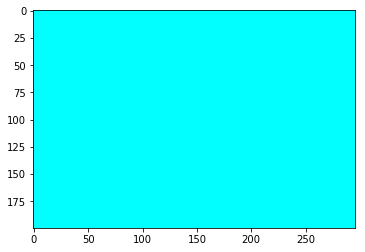

In [98]:
plt.imshow(res[7])
plt.show()